In [1]:
import pandas as pd
import csv
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
from PIL import Image

In [2]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Data.zip"

In [4]:
# CSV file path
csv_file_path = "/content/annotations.csv"  # Update with your CSV file path

# Dictionary to store image labels indexed by image path
Image_Pathes = []
Order=[]

# Read image labels from CSV file
with open(csv_file_path, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
      image_path=f"/content/images/{row['file_name']}"
      Image_Pathes.append(image_path)
      Order.append(row["category"])

In [5]:
label_encoder = LabelEncoder()
Order = label_encoder.fit_transform(Order)

In [6]:

def read_grayscale(image_path):
    # Read image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image



def resize_images(images, target_size):
    resized_images = []
    for img in images:
        pil_img = Image.fromarray(img)
        resized_img = pil_img.resize(target_size)
        resized_img_array = np.array(resized_img)
        resized_images.append(resized_img_array)
    return resized_images


In [7]:
Images = []
for image_path in Image_Pathes:
    # Read image in grayscale and append to the list
    Images.append(read_grayscale(image_path))

resized_images = resize_images(Images, (128, 128))
Images=resized_images

Order:  46


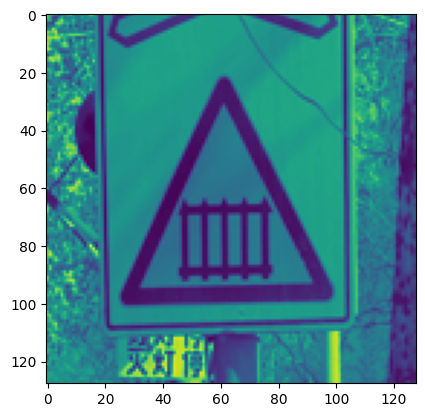

In [8]:
plt.imshow(Images[900])
print("Order: ",Order[900])

In [9]:
X_train, x_test, Y_train, y_test = train_test_split(Images, Order, test_size=0.33, random_state=42)

In [10]:
X_train = np.array([np.expand_dims(image, axis=-1) for image in X_train])

x_test = np.array([np.expand_dims(image, axis=-1) for image in x_test])

In [30]:
datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False,  # randomly flip images vertically
    fill_mode='nearest'  # strategy used for filling in newly created pixels
)

# Fit the data generator to your training data
datagen.fit(X_train)

# Create a generator to yield augmented images
augmented_generator = datagen.flow(X_train, Y_train, batch_size=32)

In [11]:
model=tf.keras.Sequential([
    tf.keras.Input(shape=(128,128,1)),
    tf.keras.layers.Conv2D(128,3,padding="same",activation="relu"),
    tf.keras.layers.Conv2D(64,3,padding="same",activation="relu"),
        tf.keras.layers.Dropout(.2),
    tf.keras.layers.Conv2D(32,3,padding="same",activation="relu"),
    tf.keras.layers.Conv2D(32,3,padding="same",activation="relu"),
        tf.keras.layers.Dropout(.2),
    tf.keras.layers.Conv2D(16,3,padding="same",activation="relu"),
    tf.keras.layers.Conv2D(16,3,padding="same",activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150,activation="relu"),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.Dense(58,activation="softmax")
])

In [12]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam',metrics='accuracy')

In [38]:
history=model.fit(
    augmented_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=20,
    validation_data=(x_test,y_test))

Epoch 1/20
129/129 [==============================] - 19s 145ms/step - loss: 0.2943 - accuracy: 0.9051 - val_loss: 0.2470 - val_accuracy: 0.9150
Epoch 2/20
129/129 [==============================] - 17s 134ms/step - loss: 0.2951 - accuracy: 0.9055 - val_loss: 0.2762 - val_accuracy: 0.9101
Epoch 3/20
129/129 [==============================] - 17s 134ms/step - loss: 0.3625 - accuracy: 0.8833 - val_loss: 0.3050 - val_accuracy: 0.9042
Epoch 4/20
129/129 [==============================] - 19s 143ms/step - loss: 0.2648 - accuracy: 0.9134 - val_loss: 0.2314 - val_accuracy: 0.9273
Epoch 5/20
129/129 [==============================] - 19s 143ms/step - loss: 0.2868 - accuracy: 0.9038 - val_loss: 0.3137 - val_accuracy: 0.9012
Epoch 6/20
129/129 [==============================] - 19s 144ms/step - loss: 0.2959 - accuracy: 0.9048 - val_loss: 0.5088 - val_accuracy: 0.8246
Epoch 7/20
129/129 [==============================] - 17s 134ms/step - loss: 0.3054 - accuracy: 0.9016 - val_loss: 0.2472 - val_ac

In [39]:
_,accuracy=model.evaluate(x_test,y_test)
print('Accuracy=%2f'%(accuracy*100))

64/64 [==============================] - 1s 22ms/step - loss: 0.2500 - accuracy: 0.9174
Accuracy=91.744471


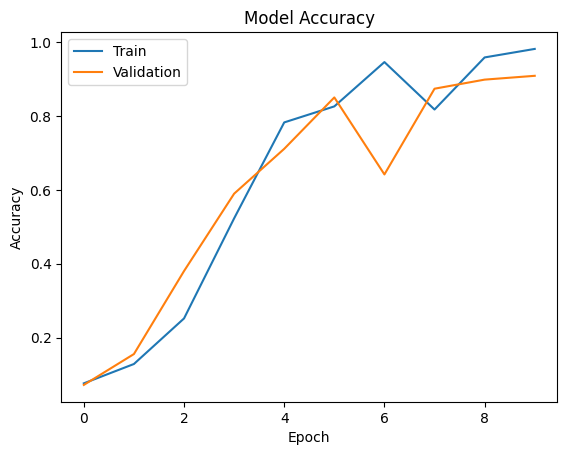

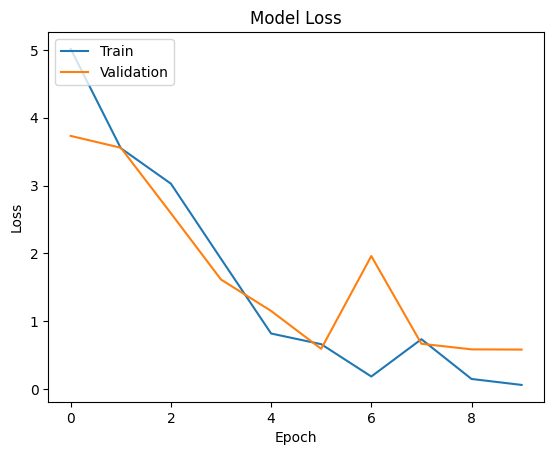

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()